## **Synthetic data generation**

For our fine-tuning data, we will use the [NoteChat](https://arxiv.org/abs/2310.15959) dataset [(Huggingface link)](https://huggingface.co/datasets/akemiH/NoteChat). This dataset contains 167K pairs of real clinical notes extracted from [PMC-Patients](https://arxiv.org/abs/2202.13876) with generated patient-doctor conversations.

<p align="center">
<img src="figures/notechat.png" width="50%">
</p>

In this notebook, we extend this dataset of pairs to triplets with GPT-3.5: 


(`clinical note`, `dialogue transcript`) $\to$ (`clinical note`, `dialogue transcript`, `patient summary`)

We extract patient summaries by prompting GPT-3.5 with a clinical note, its corresponding dialogue transcript and a comprehensive template of patient features. 

In [3]:
#!pip install -r requirements.txt
import os
from utils.chat import *
from datasets import load_dataset
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

### 1. **Load NoteChat data**

We first take a look at the NoteChat dataset. We load the dataset from the Huggingface library and display a few examples.

In [ ]:
df_path = 'data/NoteChat.jsonl'

if not os.path.exists(df_path):
    dataset = load_dataset("akemiH/NoteChat")
    data = dataset['train'].to_pandas()
    data.to_json('data/NoteChat.jsonl', orient='records', lines=True)

else:
    data = pd.read_json(df_path, orient='records', lines=True)

data = data.sort_values(by=['data'], ascending=False)

data


,data,conversation
163999,"“Z,” a 14-year-old girl, was referred to our c...","Doctor: Hello, Z. I'm Dr. X, and I'll be your ..."
66442,"“Theresa” was a widowed, White British woman i...","\nDoctor: Hi Theresa, how are you today?\n\nTh..."
33502,“Sami Rami” is a 5-year and 8-month-old boy fr...,"\nDoctor: Hi, I’m Dr. X. How are you doing tod..."
70760,"“Mr. L” was a 54-year-old single, jobless man....","\nDoctor: Hello Mr. L, I am Dr. X. How are you..."
50554,"“Mr. D” is a 42-year-old man, presently living...","Doctor: Hello Mr. D, I'm Dr. X. How are you fe..."
...,...,...
181740,(1) A 30 y.o. P0+1 underwent a successful ovul...,"Doctor: Hello, how can I help you today?\nPati..."
191740,(1) A 30 y.o. P0+1 underwent a successful ovul...,"Doctor: Hello, how can I help you today?\nPati..."
104501,()A 34 year-old African American male with no ...,"\nDoctor: Good morning, may I have your name?\..."
134012,() A 53-year-old man was diagnosed with Rai II...,"\nDoctor: Good morning, sir. How are you feeli..."


In [ ]:
data.iloc[0]['data']

'“Z,” a 14-year-old girl, was referred to our child psychiatry clinic because she was experiencing a mania episode. Both a magnetic resonance imaging scan and an electroencephalography revealed no hint of an organic cause of her manic symptoms. Since her history also revealed a depressive episode, she was diagnosed as having bipolar disorder type 1 using the Kiddie-Sads-Present and Lifetime Version. Then, the Young Mania Rating Scale was used to measure the severity of her manic symptoms; her score was 45.\nWe started treatment with SV 250 mg/day for the first 4 days. We also administered risperidone 1 mg/day to resolve the ideas of reference symptom throughout the course of treatment. At the 15th day, the dose of SV was titrated to 750 mg/day (250 mg at noon and 500 mg at night). Since the SV dose reached 750mg/day Z began bedwetting. About 4 weeks later, when the dose of SV was titrated up to 500mg twice a day (a blood level of 75μg/ml), Z developed diurnal and nocturnal enuresis eve

In [ ]:
note = data['data'][0].replace('. ', '.\n')
conversation = data['conversation'][0].strip()  

print('CLINICAL NOTE')
print(note)
print('\n\nCONVERSATION')
print(conversation.replace('\n\n', '\n'))

CLINICAL NOTE
This 60-year-old male was hospitalized due to moderate ARDS from COVID-19 with symptoms of fever, dry cough, and dyspnea.
We encountered several difficulties during physical therapy on the acute ward.
First, any change of position or deep breathing triggered coughing attacks that induced oxygen desaturation and dyspnea.
To avoid rapid deterioration and respiratory failure, we instructed and performed position changes very slowly and step-by-step.
In this way, a position change to the 135° prone position () took around 30 minutes.
This approach was well tolerated and increased oxygen saturation, for example, on day 5 with 6 L/min of oxygen from 93% to 97%.
Second, we had to adapt the breathing exercises to avoid prolonged coughing and oxygen desaturation.
Accordingly, we instructed the patient to stop every deep breath before the need to cough and to hold inspiration for better air distribution.
In this manner, the patient performed the breathing exercises well and managed

### 2. **Experiment with extraction of patient summaries**


$$\text{Prompt} + \text{Clinical note} + \text{Template (with definitions?)} \to \text{Patient summary}$$

We will have to test out a few options to see which one works best.

- **Clinical note and/or dialogue transcript?** Dialogue is generated from clinical note, so all information contained in the dialogue should be in the clinical note --> only use clinical note?

- **Zero-shot vs. One-shot?** Do we include an example of (clinical note, dialogue transcript, patient summary) in the prompt? Ideally yes, but it might not fit in the prompt. If we remove the dialogue, it might fit better. 
--> Zero-shot to fit into context. 

- **Template definitions?** Do we include definitions of the template in the prompt? Adding the definitions might not help, and might not fit in the prompt. 

After a few tests, we choose to generate using only clinical notes, zero-shot and using a template with definitions. 

In [ ]:
# Load the extraction prompt
instruction_path = 'generation/instructions/instructions.txt'
with open('generation/instructions/instructions.txt', 'r') as f:
    instructions = f.read()

print(instructions)

Given the provided clinical note, extract the corresponding patient summary following the template provided. 
Be as thorough as possible to extract all the information from the clinical note, but do not add any new information. 
Make sure all details mentioned in the clinical note appear in your output. If necessary add more field at the end of the template.
If a field is not mentioned, simply write "feature": None.


In [ ]:
# Load the template
with open('generation/templates/template.json', 'r') as f:
    template = json.load(f)

# Load the template definitions
with open('generation/templates/template_definitions.json', 'r') as f:
    template_def = json.load(f)

template_def

{'visit motivation': "Reason for the patient's visit",
 'admission': [{'reason': 'Reason for admission to a care center',
   'date': 'Date of first admission',
   'duration': "Length of patient's stay",
   'center': 'Name, type and details of care center'}],
 'patient information': {'age': "Patient's age",
  'sex': "Patient's sex",
  'ethnicity': "Patient's ethnicity or nationality",
  'weight': "Patient's weight",
  'height': "Patient's height",
  'family medical history': 'Information about family medical history',
  'recent travels': "Details about patient's recent travels",
  'socio economic context': "Patient's socioeconomic background",
  'occupation': "Patient's occupation"},
 'patient medical history': {'physiological context': 'Relevant physiological history of the patient',
  'psychological context': 'Relevant psychological history of the patient',
  'vaccination history': 'History of vaccinations received by the patient',
  'allergies': 'Any known allergies of the patient',


In [ ]:
notechat = pd.read_json('data/NoteChat.jsonl', orient='records', lines=True)
# Sort by decreasing length of clinical note
notechat['length'] = notechat['data'].apply(lambda x: len(x.split()))   
notechat = notechat.sort_values(by=['length'], ascending=False)
display(notechat.head(10))
notechat = notechat.drop(columns=['length'])
notechat['idx'] = notechat.index
notechat.to_json('data/NoteChat_sorted.jsonl', orient='records', lines=True)

,data,conversation,length
155216,"A a sixteen year-old girl, presented to our Ou...","\nDoctor: Good morning, what brings you to the...",360
77465,This is the case of a 56-year-old man that was...,"Doctor: Hi, how are you feeling today?\nPatien...",353
133948,A 36-year old female patient visited our hospi...,"\nDoctor: Hello, what brings you to the hospit...",353
80176,A 49-year-old male presented with a complaint ...,"\nDoctor: Good morning, Mr. [Patient's Name]. ...",352
72232,A 47-year-old male patient was referred to the...,"\nDoctor: Good morning, how are you feeling to...",351
31864,A 24-year-old Yemeni female presented to the e...,"Doctor: Good morning, how are you feeling toda...",351
26809,We report a 24-day-old female baby who present...,"Doctor: Hi there, I am Dr. Smith. How can I he...",350
149866,A 16 years old female patient presented to us ...,"Doctor: Good morning, what brings you here tod...",350
87064,We present a case of a seventy-three-year-old ...,"Doctor: Good morning, sir. How can I help you ...",350
123006,A 23-year-old female patient was admitted to a...,"\nDoctor: Hi, how are you feeling today?\n\nPa...",350


In [ ]:
import tiktoken
def count_tokens(note: str):
    encoding = tiktoken.encoding_for_model('gpt-4')
    num_tokens = len(encoding.encode(note))
    return num_tokens

In [ ]:
notechat = pd.read_json('data/NoteChat.jsonl', orient='records', lines=True)
#Sort by decreasing length of clinical note
notechat['length'] = notechat['data'].apply(lambda x: count_tokens(x))   
notechat_token_sorted = notechat.sort_values(by=['length'], ascending=False)
display(notechat_token_sorted.head(100))
#notechat_token_sorted = notechat_token_sorted.drop(columns=['length'])
notechat_token_sorted.to_json('data/NoteChat_sorted_token.jsonl', orient='records', lines=True)

,data,conversation,length
15675,The medical history of 44-year old male kidney...,"Doctor: Good morning, can you tell me a little...",529
30182,A 66-year-old male with chronic hypoxemic resp...,"Doctor: Good morning, how are you feeling toda...",524
64786,An outborn male neonate was delivered vaginall...,"\nDoctor: Hello, how are you feeling today?\n\...",522
140140,Patient: 71-year-old male.\nMain symptoms: fev...,"\nDoctor: Good morning, sir. How are you feeli...",521
140324,"P, a 25-year-old male with unknown native kidn...","Doctor: Good morning, sir. How can I help you ...",517
...,...,...,...
125647,62 year old female was diagnosed seropositive ...,"\nDoctor: Hello, Mrs. How are you feeling toda...",502
91853,"A nonsmoking 67-year-old woman, diagnosed of n...","Doctor: Good morning, can you tell me what's g...",501
82294,A 28-year-old female was initiated on high-dos...,"Doctor: Good morning, how are you feeling toda...",501
155201,"A 72-year-old man, previously healthy, was adm...","\nDoctor: Good morning, how are you feeling to...",501


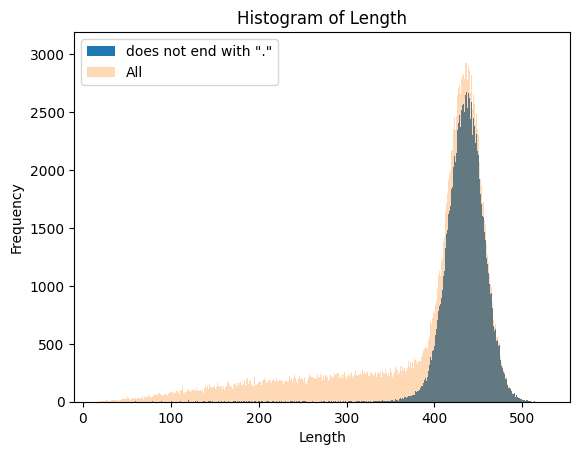

In [ ]:
import matplotlib.pyplot as plt

# Filter out clinical notes where the last character of "data" is not '.'
notechat_token_truncated = notechat_token_sorted[~notechat_token_sorted['data'].str.endswith('.')]

# Calculate the length of each clinical note
lengths_filtered = notechat_token_truncated['length']
lengths_all = notechat_token_sorted['length']

# Create the histogram with transparency
plt.hist(lengths_filtered, bins=max(lengths_filtered)-min(lengths_filtered)+1, alpha=1, label='does not end with "."')
plt.hist(lengths_all, bins=max(lengths_all)-min(lengths_all)+1, alpha=0.3, label='All')

# Set the labels and title
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Length')

# Show the legend
plt.legend()

# Show the plot
plt.show()


In [3]:
model = 'gpt-4-1106-preview' #for token count only
chat = chat_gpt_4_turbo
template_path = 'generation/templates/template_definitions.json'
instruction_path = 'generation/instructions/instructions.txt'
data_path = 'data/NoteChat_sorted.jsonl'
save_path = 'generation/saves/summaries_full_gen.jsonl'
keys_path = 'generation/keys.json'
max_tokens= 500000
nb_to_generate =30000

In [4]:
extract(
    model = model,
    chat = chat,
    template_path=template_path,
    instruction_path=instruction_path,
    data_path=data_path,
    save_path=save_path,
    use_notes=True, 
    use_dialogues=False,
    max_tokens= max_tokens,
    nb_to_generate = nb_to_generate)

Loading Data...
Looking for already generated summaries...
21625 generations already done. Skipping them.
Loading template...
Loading instructions...
Building prompts...


100%|██████████| 8375/8375 [00:01<00:00, 4406.69it/s]


Building messages...


100%|██████████| 8375/8375 [00:00<00:00, 36690.95it/s]


Creating sub-batches...


100%|██████████| 8375/8375 [00:39<00:00, 212.15it/s]


Created 24 sub-batches with token number:[(355, 499262), (355, 499713), (354, 498731), (354, 498864), (354, 498869), (354, 498696), (354, 498984), (354, 498617), (354, 498818), (355, 499923), (355, 499960), (354, 498645), (355, 499687), (355, 499073), (355, 499439), (355, 499701), (354, 498899), (355, 499714), (355, 499729), (354, 499366), (355, 499831), (354, 499064), (354, 498794), (222, 312342)]
Sub_batch 1/24: 355 calls, 499262 total tokens: 4.9926200000000005$
...................20
...................40
...................60
...................80
...................100
...................120
...................140
...................160
...................180
...................200
...................220
...................240
...................260
...................280
...................300
...................320
...................340
...............
Sub-batch 1 Saved (size 355)


Break for 5 seconds.
End of break.
Sub_batch 2/24: 355 calls, 499713 total tokens: 4.99713$
....

,data,conversation,idx,summary
0,"A a sixteen year-old girl, presented to our Ou...","\nDoctor: Good morning, what brings you to the...",155216,"{\n ""visit motivation"": ""Discomfort in the ..."
1,This is the case of a 56-year-old man that was...,"Doctor: Hi, how are you feeling today?\nPatien...",77465,"{\n ""visit motivation"": ""Complaints of a du..."
2,A 36-year old female patient visited our hospi...,"\nDoctor: Hello, what brings you to the hospit...",133948,"{\n ""visit motivation"": ""Pain and restricte..."
3,A 49-year-old male presented with a complaint ...,"\nDoctor: Good morning, Mr. [Patient's Name]. ...",80176,"{\n ""visit motivation"": ""Pain in the left p..."
4,A 47-year-old male patient was referred to the...,"\nDoctor: Good morning, how are you feeling to...",72232,"{\n ""visit motivation"": ""Recurrent attacks ..."
...,...,...,...,...
29995,A 28-year-old male was admitted to the emergen...,"\nDoctor: Good morning, sir. Can you tell me w...",39279,"{\n ""visit motivation"": ""Stab wound under l..."
29996,"An 82-year-old man (64.5 kg, 175 cm) diagnosed...","Doctor: Good morning, sir. I am Dr. John. How ...",137017,"{\n ""visit motivation"": ""Diagnosed with fal..."
29997,A 54 year-old man with no past medical history...,"\nDoctor: Good morning, how are you feeling to...",98004,"{\n ""visit motivation"": ""Cardiac sounding c..."
29998,A 49-year-old woman visited the clinic due to ...,"Doctor: Good morning, how can I help you today...",133320,"{\n ""visit motivation"": ""Mass in her right ..."


### 3. **Generate triplets**

Once we have a good prompting strategy, we generate triplets for the whole dataset.


In [12]:
import re

def formatting(summary): 
    summary = summary.replace('. ', '.\n')
    summary = summary.replace('None', '"None"')
    summary = re.sub(r'\n\s+"', '\n"', summary)
    summary = re.sub(r'\n\s+{', '\n{', summary)
    summary = re.sub(r'\n\s+}', '\n}', summary)
    summary = re.sub(r'\n\s+}', '\n]', summary)
    summary = re.sub(r'\n\s+]', '\n]', summary)
    return summary

with open('generation/instructions/summarize.txt', 'r') as f:
    summarizer_prompt = f.read()
with open('generation/instructions/generate.txt', 'r') as f:
    generator_prompt = f.read()

summaries = pd.read_json('generation/summaries/summaries_30K.jsonl', lines=True)
summaries['summary'] = summaries['summary'].apply(formatting)          
summaries['data'] = summaries['data'].apply(lambda x: x.strip())
summaries['conversation'] = summaries['conversation'].apply(lambda x: x.strip().replace('\n\n', '\n'))

summarizer = summaries.copy()
summarizer['prompt'] = summarizer_prompt + '\n\n' + summarizer['conversation']
summarizer['gold'] = summarizer['summary']
summarizer = summarizer.drop(columns=['conversation', 'summary', 'data'])
summarizer.to_json('generation/summaries/summarizer_30K.jsonl', orient='records', lines=True)

generator = summaries.copy()
generator['prompt'] = generator_prompt + '\n\n' + generator['summary']
generator['gold'] = generator['data']
generator = generator.drop(columns=['summary', 'data', 'conversation'])
generator.to_json('generation/summaries/generator_30K.jsonl', orient='records', lines=True)

{
"visit motivation": "Discomfort in the neck and lower back, restriction of body movements, inability to maintain an erect posture, and requiring assistance in standing and walking.",
"admission": [
{
"reason": "None",
"date": "None",
"duration": "None",
"care center details": "None"
}
],
"patient information": {
"age": "Sixteen years old",
"sex": "Female",
"ethnicity": "None",
"weight": "None",
"height": "None",
"family medical history": "None",
"recent travels": "None",
"socio economic context": "None",
"occupation": "None"
},
"patient medical history": {
"physiological context": "None",
"psychological context": "Diagnosed with bipolar affective disorder at the age of eleven, first episode was that of mania.",
"vaccination history": "None",
"allergies": "None",
"exercise frequency": "None",
"nutrition": "None",
"sexual history": "None",
"alcohol consumption": "None",
"drug usage": "None",
"smoking status": "None"
},
"surgeries": [
{
"reason": "None",
"Type": "None",
"time": "None",


In [14]:
# Do a random train-test split with test ratio 0.1 for both summarizer and generator
from sklearn.model_selection import train_test_split
summarizer_train, summarizer_test = train_test_split(summarizer, test_size=0.1, random_state=42)
generator_train, generator_test = train_test_split(generator, test_size=0.1, random_state=42)

summarizer_train.to_json('generation/summaries/summarizer_train.jsonl', orient='records', lines=True)
summarizer_test.to_json('generation/summaries/summarizer_test.jsonl', orient='records', lines=True)
generator_train.to_json('generation/summaries/generator_train.jsonl', orient='records', lines=True)
generator_test.to_json('generation/summaries/generator_test.jsonl', orient='records', lines=True)

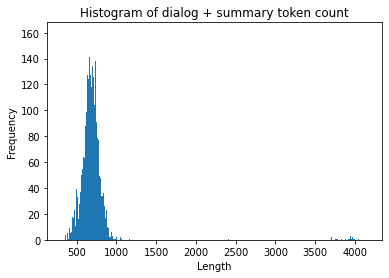

In [11]:
summarizer = pd.read_json('generation/summaries/summarizer_30K.jsonl', orient='records', lines=True)
encoder = tiktoken.encoding_for_model('gpt-4')
summarizer['length'] = summarizer.apply(lambda row: len(encoder.encode(row['prompt'])), axis=1)
plt.hist(summarizer['length'], bins=max(summarizer['length'])-min(summarizer['length'])+1)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of dialog + summary token count')
plt.show()

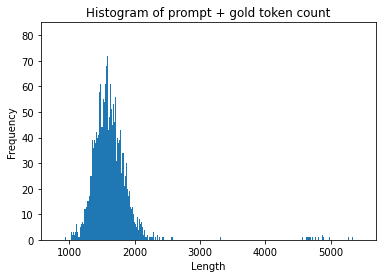

In [9]:
summarizer = pd.read_json('generation/summaries/summarizer_30K.jsonl', orient='records', lines=True)
encoder = tiktoken.encoding_for_model('gpt-4')
summarizer['length'] = summarizer.apply(lambda row: len(encoder.encode(row['prompt']) + encoder.encode(row['gold'])), axis=1)
plt.hist(summarizer['length'], bins=max(summarizer['length'])-min(summarizer['length'])+1)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of dialog + summary token count')
plt.show()